[kaggle-california-house](https://www.kaggle.com/c/california-house-prices/overview)

参考与前言

课程链接：跟李沐学AI的个人空间_哔哩哔哩_bilibili<br>
课程主页：https://zh-v2.d2l.ai/chapter_multilayer-perceptrons/kaggle-house-price.html<br>
相关代码参考：https://www.kaggle.com/alexandreazhang/using-dl-to-predict-housing-prices/notebook<br>
本部分主要用于记录自己做第一次作业的一些感受 主要是emmm 也是第一次看这么仔细，虽然最后还是不如沐神的十行代码 hhhh 但是还是总结一下较好，本来是想弄一弄懂注意力那个算法是咋个计算方式 还有最近看的GRU那几个点，但是沐神太吸引人了 hhh 所以就实战了一下 

首先遇到的问题：

* one hot后太多feature了!
* learning_rate 一开始直接成0了
* 后面有遇到梯度不平稳情况，虽然有weight_decay 但是emm 好像哪里不太对
* 训练和输入数据维度不一样

解决：

可能第一次接触大数据处理，GPU显存，和本地内存都大大不够用，总想着把数据少读取点，或者拆分处理，但实际白费了很多功夫，核心问题是很多标签object太多，转成one-hot后维度太多；**最好的做法是选取少量特征的全部训练数据即可。**    
训练和输入数据维度不一样：重新定义模型输入层然后读取训练模型参数

In [1]:
 %matplotlib inline
import numpy as np
import pandas as pd
import torch
import os
from torch import nn
from d2l import torch as d2l

In [2]:
train_file = os.path.join('.', 'data', 'california_train.csv')
test_file = os.path.join('.', 'data', 'california_test.csv')
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

In [3]:
print(train_data.shape)
print(test_data.shape)

(47439, 41)
(31626, 40)


In [4]:
# 数据预处理
train_data_drop = train_data.drop(columns='Sold Price') #train.data去掉第0列和第2列,test_data去掉第0列
all_features = pd.concat((train_data_drop.iloc[:, 1:], test_data.iloc[:, 1:])) #pd.concat拼接
all_features.shape

(79065, 39)

In [5]:
# numeric处理和归一化
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [6]:
# 最好的做法，只选取两个type
features = list(numeric_features)
# 加上类别数相对较少的Type
features.extend(['Type','Bedrooms'])
all_features = all_features[features]
all_features.shape

(79065, 20)

In [7]:
#  one-hot:object处理
#  注意内存分配大小,拆分处理选取部分特征
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(79065, 471)

In [8]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data['Sold Price'].values.reshape(-1, 1), dtype=torch.float32) #SalePrice

In [9]:
train_labels.shape

torch.Size([47439, 1])

In [10]:
# train
loss = nn.MSELoss()
in_features = train_features.shape[1]

# 简介实现MLP
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 256),
                nn.ReLU(),
                # 在第⼀个全连接层之后添加⼀个dropout层
                nn.Dropout(0.2),
                nn.Linear(256, 64),
                nn.ReLU(),
                nn.Linear(64, 1))   #预测出Sold Price
    return net

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net = get_net()
net.apply(init_weights);

In [11]:
#模型转换至GPU上进行运算：需要转换的对象：模型，数据,损失函数
#nvidia-smi，终止进程，节省显存
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") net = net.to(device)
if torch.cuda.is_available():
    net = net.cuda()
    loss = loss.cuda()
    train_features = train_features.cuda()
    train_labels = train_labels.cuda() 
    test_features = test_features.cuda()

In [12]:
#对数对相对误差很有用
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf')) #1到正无穷
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item() #返回浮点数，确保精度

In [13]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [14]:
# K折（5）交叉验证选取超参数，调节精度
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [15]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        net = net.cuda()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.326887, 验证log rmse0.365542
折2，训练log rmse0.326882, 验证log rmse0.327492
折3，训练log rmse0.459055, 验证log rmse0.486830
折4，训练log rmse0.451138, 验证log rmse0.451695
折5，训练log rmse0.341709, 验证log rmse0.393849
5-折验证: 平均训练log rmse: 0.381134, 平均验证log rmse: 0.405082


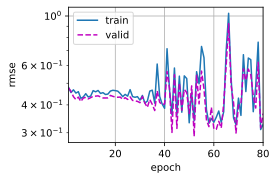

In [16]:
k, num_epochs, lr, weight_decay, batch_size = 5, 80, 0.03, 0.03, 128 #Relu:lr要低
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [17]:
k, num_epochs, lr, weight_decay, batch_size = 5, 80, 0.03, 0.03, 128

**提交你的Kaggle预测**

In [18]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    net = net.cuda()  
    # 所有数据训练
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    torch.save(net.state_dict(),"net_state_dict.ckpt")
    
    # 将网络应用于测试集,net(test_features):存储预测结果
    in_features = test_features.shape[1] #注意训练和测试数据输入维度不一样！
    net = get_net()
    net = net.cuda() 
    #读取参数
    checkpoint = torch.load("net_state_dict.ckpt")
    net.load_state_dict(checkpoint)
    # Tensor.cpu()才能保存numpy
    preds_gpu = net(test_features).detach()
    preds_cpu = preds_gpu.cpu()
    preds = preds_cpu.numpy()
    
    # 将其重新格式化以导出到Kaggle
    test_data['Sold Price'] = pd.Series(preds.reshape(1, -1)[0])#test_data['Sold Price'].values = preds.reshape(-1, 1)[0]
    submission = pd.concat([test_data['Id'], test_data['Sold Price']], axis=1)
    submission.to_csv('california_submission.csv', index=False)

训练log rmse：0.512145


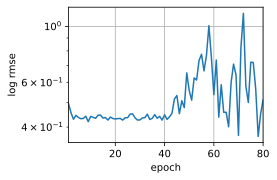

In [19]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

由于内存有限，只选取了两个标签，所以训练后面就emmmm~
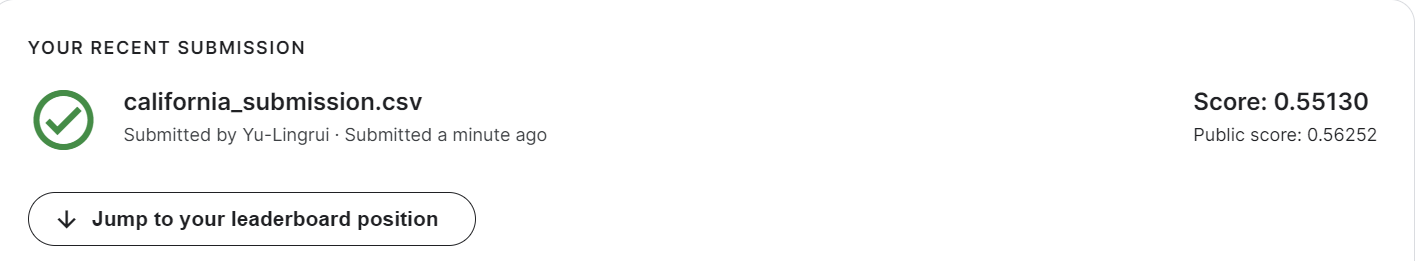

**沐神的十行代码：**  
**自动调参、集成模型，自己只需处理数据:超参数搜索，融，集成，K折**  
论文：https:l/arxv,org/abs/2003.06505    
竞赛地址：https://www.kaggle.com/c/california-house-prices/overview    
autogluon文档：https://auto.gluon.ai/    
autogluon代码：https://github.com/awslabs/autogluon

In [ ]:
'''
最好基于Linux：
install.sh
#创建并激活Python3.8的环境
conda create -y --force -n ag python=3.8 pip
conda activate ag
#安装autogluon
pip install "mxnet<2.0.0"
pip install autogluon
文本数据处理：集成学习，transformer
'''
from autogluon.tabular import TabularDataset,TabularPredictor
import numpy as np
train_data = TabularDataset('train.csv')
id,label = 'Id','Sold Price'
#数据预处理
large_val_cols ['Lot','Total interior livable area',
'Tax assessed value','Annual tax amount',
'Listed Price','Last Sold Price']
for c in large_val_cols [label]:
train_data[c]np.log(train_data[c]+1)
predictor TabularPredictor(label=label).fit(
    
#训练   
from autogluon.tabular import TabularDataset,TabularPredictor
train_data TabularDataset('train.csv')
predictor TabularPredictor(label=label).fit(
    train_data.drop(columns=[id])) #fit适应模型
#更好的模型：
hyperparameters='multimodal'#transfomer来提取特征-gpu
num_stack_levels=1,num_bag_folds=5  
    
#预测
import pandas as pd
test_data TabularDataset('test.csv'
preds predictor.predict(test_data.drop(columns=[id]))
submission pd.DataFrame({id:test_data[id],label:preds})
submission.to_csv('submission.csv',index=False)